In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
# import data
portion = pd.read_csv("C:/Users/ilove/Desktop/KU-BIG/project_time_series/data/portion_data.csv",
                     names=['time', 'value'])

In [3]:
portion.head()

,time,value
0,2016-01-01 00:00:00,0.040664
1,2016-01-01 01:00:00,0.040585
2,2016-01-01 02:00:00,0.041324
3,2016-01-01 03:00:00,0.042763
4,2016-01-01 04:00:00,0.043817


In [4]:
portion.time = pd.to_datetime(portion['time'])
portion = portion.set_index('time')

In [5]:
portion.head()

,value
time,
2016-01-01 00:00:00,0.040664
2016-01-01 01:00:00,0.040585
2016-01-01 02:00:00,0.041324
2016-01-01 03:00:00,0.042763
2016-01-01 04:00:00,0.043817


In [6]:
portion.shape

(8784, 1)

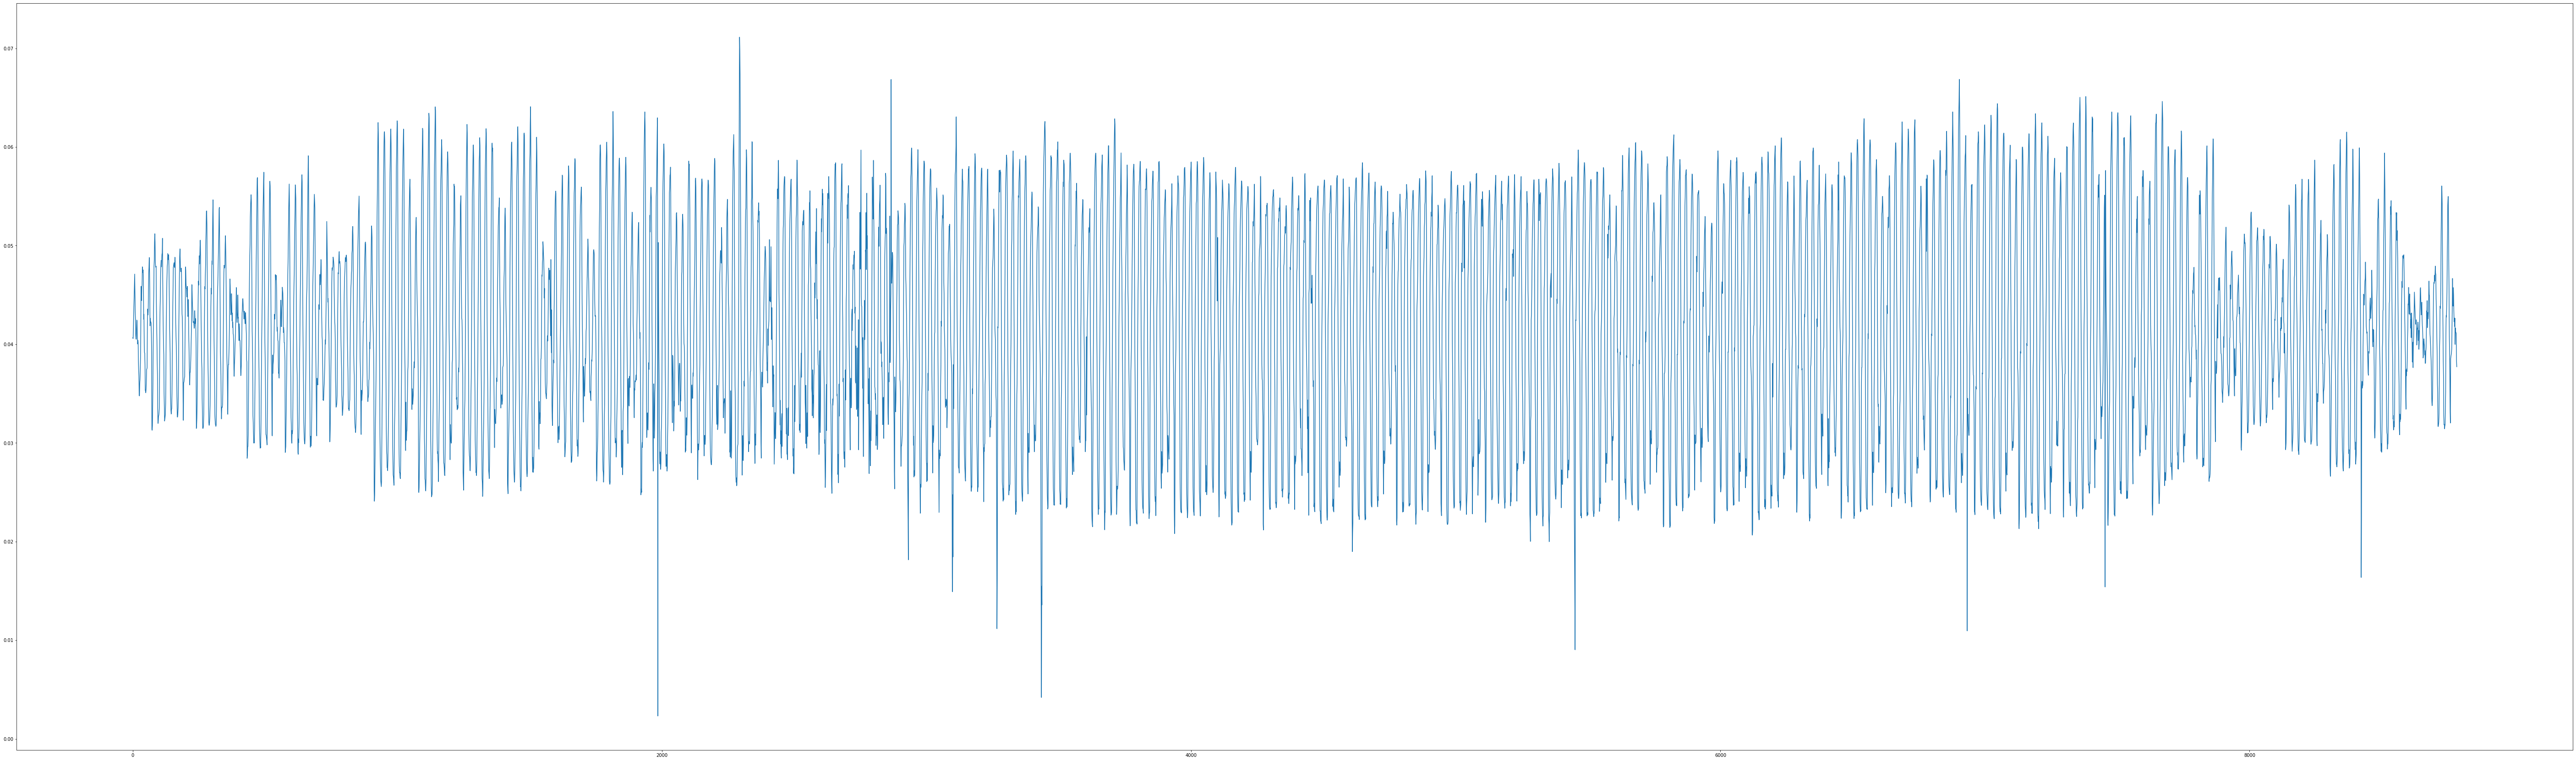

In [7]:
#EDA
values = portion.values
plt.figure(figsize=(100,30))
plt.plot(values)
plt.show()

In [8]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [9]:
window_size = 24
# frame as supervised learning
reframed = series_to_supervised(values, 24, 1)
reframed.head()

,var1(t-24),var1(t-23),var1(t-22),var1(t-21),var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),var1(t-15),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
24,0.040664,0.040585,0.041324,0.042763,0.043817,0.044726,0.045758,0.047115,0.045295,0.043373,...,0.042453,0.042181,0.040829,0.040033,0.040405,0.040207,0.038334,0.037257,0.036768,0.034823
25,0.040585,0.041324,0.042763,0.043817,0.044726,0.045758,0.047115,0.045295,0.043373,0.042492,...,0.042181,0.040829,0.040033,0.040405,0.040207,0.038334,0.037257,0.036768,0.034823,0.034765
26,0.041324,0.042763,0.043817,0.044726,0.045758,0.047115,0.045295,0.043373,0.042492,0.040934,...,0.040829,0.040033,0.040405,0.040207,0.038334,0.037257,0.036768,0.034823,0.034765,0.035971
27,0.042763,0.043817,0.044726,0.045758,0.047115,0.045295,0.043373,0.042492,0.040934,0.040550,...,0.040033,0.040405,0.040207,0.038334,0.037257,0.036768,0.034823,0.034765,0.035971,0.036407
28,0.043817,0.044726,0.045758,0.047115,0.045295,0.043373,0.042492,0.040934,0.040550,0.040507,...,0.040405,0.040207,0.038334,0.037257,0.036768,0.034823,0.034765,0.035971,0.036407,0.037375


In [10]:
#split train and test
values=reframed.values
n_train_hours = 335*24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [11]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], window_size, int(train_X.shape[1]/window_size)))
test_X = test_X.reshape((test_X.shape[0], window_size, int(test_X.shape[1]/window_size)))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8040, 24, 1) (8040,) (720, 24, 1) (720,)


In [12]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [13]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 8040 samples, validate on 720 samples
Epoch 1/50
 - 5s - loss: 0.0119 - val_loss: 0.0055
Epoch 2/50
 - 3s - loss: 0.0047 - val_loss: 0.0023
Epoch 3/50
 - 3s - loss: 0.0023 - val_loss: 0.0018
Epoch 4/50
 - 4s - loss: 0.0023 - val_loss: 0.0021
Epoch 5/50
 - 5s - loss: 0.0023 - val_loss: 0.0017
Epoch 6/50
 - 5s - loss: 0.0022 - val_loss: 0.0017
Epoch 7/50
 - 4s - loss: 0.0021 - val_loss: 0.0017
Epoch 8/50
 - 4s - loss: 0.0022 - val_loss: 0.0017
Epoch 9/50
 - 3s - loss: 0.0021 - val_loss: 0.0016
Epoch 10/50
 - 3s - loss: 0.0021 - val_loss: 0.0016
Epoch 11/50
 - 3s - loss: 0.0020 - val_loss: 0.0015
Epoch 12/50
 - 3s - loss: 0.0020 - val_loss: 0.0015
Epoch 13/50
 - 3s - loss: 0.0019 - val_loss: 0.0015
Epoch 14/50
 - 4s - loss: 0.0019 - val_loss: 0.0014
Epoch 15/50
 - 3s - loss: 0.0018 - val_loss: 0.0014
Epoch 16/50
 - 3s - loss: 0.0019 - val_loss: 0.0014
Epoch 17/50
 - 3s - loss: 0.0018 - val_loss: 0.0014
Epoch 18/50
 - 3s - loss: 0.0018 - val_loss: 0.0013
Epoch 19/50
 - 3s - loss: 

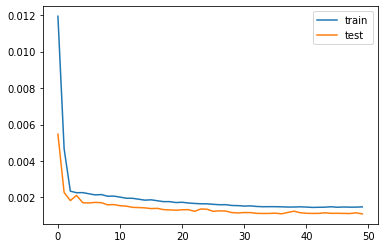

In [14]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [15]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], window_size*test_X.shape[2]))
test_X[:,1:]
# # invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:7]), axis=1)
inv_yhat = inv_yhat[:,0]

test_y
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:7]), axis=1)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.002


In [25]:
np.savetxt("C:/Users/ilove/Desktop/KU-BIG/project_time_series/data/portion_yhat.csv", inv_yhat, delimiter=",")

In [16]:
# plotting
r=np.concatenate((yhat, test_X[:, 1:7]), axis=1)
r=pd.DataFrame(r)

In [17]:
def plot_series(time, series, format="-",start=0,end=None):
    plt.plot(time[start:end],series[start:end],format)
    plt.xlabel("Time")
    plt.ylabel("meter reading")
    plt.grid(True)

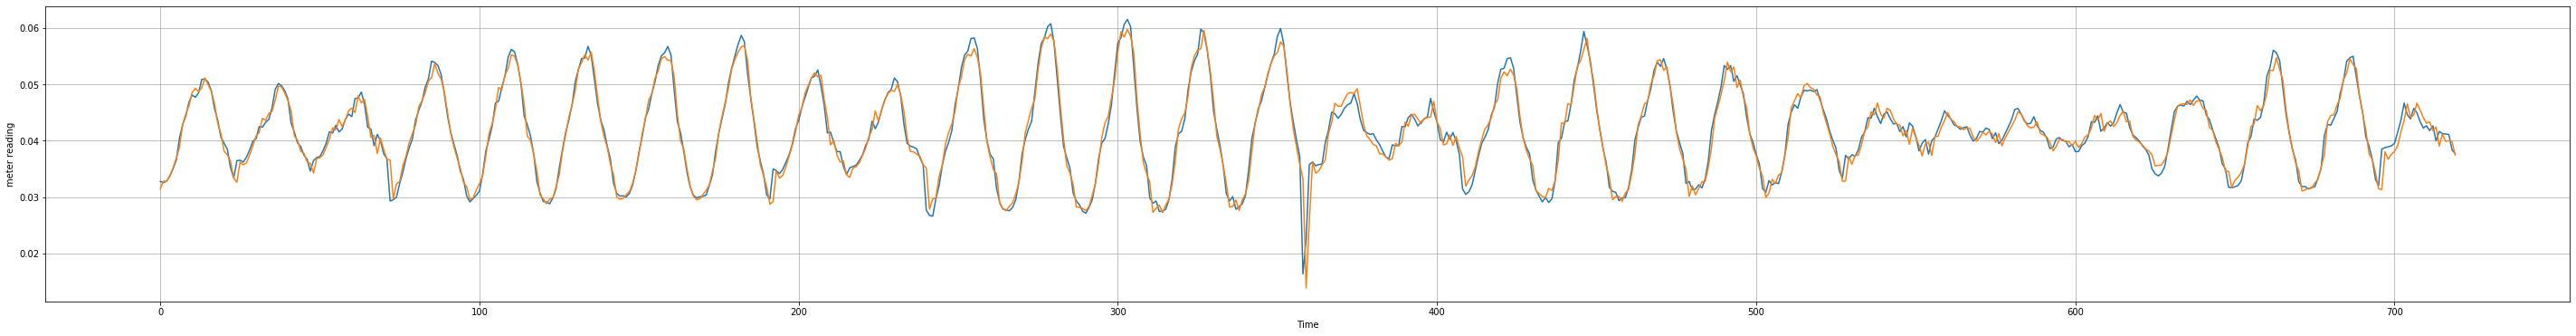

In [18]:
series = inv_y
time_step=[]
for x in range(len(series)):
    time_step.append(x)
time=np.array(time_step)
plt.figure(figsize=(50, 6))
plot_series(time,series)
plot_series(time,r[0])